In [564]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.figure_factory as ff

from sklearn.discriminant_analysis import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.metrics import accuracy_score, r2_score, ConfusionMatrixDisplay, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier

## Part 1 : EDA and data preprocessing

In [565]:
df = pd.read_csv("Walmart_Store_sales.csv")

Let's start by lowercase the columns' name and explore the df.

In [566]:
df.columns = df.columns.str.lower()

In [567]:
print(f'Number of rows: {df.shape[0]}\n')
print(f'Number of columns: {df.shape[1]}\n')
print("Display of df:\n")
display(df.head())
print('Basics statistics:\n')
display(df.describe(include='all'))
print('Percentage of missing values:\n')
missing_percentage = df.isnull().sum() * 100 / len(df)
display(missing_percentage)

Number of rows: 150

Number of columns: 8

Display of df:



,store,date,weekly_sales,holiday_flag,temperature,fuel_price,cpi,unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092


Basics statistics:



,store,date,weekly_sales,holiday_flag,temperature,fuel_price,cpi,unemployment
count,150.000000,132,1.360000e+02,138.000000,132.000000,136.000000,138.000000,135.000000
unique,NaN,85,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,19-10-2012,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
mean,9.866667,NaN,1.249536e+06,0.079710,61.398106,3.320853,179.898509,7.598430
std,6.231191,NaN,6.474630e+05,0.271831,18.378901,0.478149,40.274956,1.577173
min,1.000000,NaN,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,NaN,6.050757e+05,0.000000,45.587500,2.852250,131.970831,6.597500
50%,9.000000,NaN,1.261424e+06,0.000000,62.985000,3.451000,197.908893,7.470000
75%,15.750000,NaN,1.806386e+06,0.000000,76.345000,3.706250,214.934616,8.150000


Percentage of missing values:



store            0.000000
date            12.000000
weekly_sales     9.333333
holiday_flag     8.000000
temperature     12.000000
fuel_price       9.333333
cpi              8.000000
unemployment    10.000000
dtype: float64

The target variable corresponds to the column "weekly_sales". Let's drop the rows the value is missing.

In [568]:
df = df.dropna(subset="weekly_sales")
df.shape

(136, 8)

Let's convert the column "Date" to datetime type and create the following columns : "year", "month", "day", "day_of_week".

In [569]:
df["date"] = pd.to_datetime(df["date"], dayfirst=True)
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["day"] = df["date"].dt.day
df["day_of_week"] = df["date"].dt.dayofweek

df = df.drop("date", axis=1)

We now need to drop rows where the value in the columns Temperature, Fuel_Price, CPI and Unemployment is not in [X̄ - 3σ, X̄ + 3σ].


In [570]:
columns = ["temperature", "fuel_price", "cpi", "unemployment"]
for column in columns:
    mean = df[column].mean()
    std = df[column].std()
    df = df.drop(df[(df[column] < mean - 3*std) | (df[column] > mean + 3*std)].index)
df.shape

(131, 11)

In [571]:
df.head()

,store,weekly_sales,holiday_flag,temperature,fuel_price,cpi,unemployment,year,month,day,day_of_week
0,6.0,1572117.54,NaN,59.61,3.045,214.777523,6.858,2011.0,2.0,18.0,4.0
1,13.0,1807545.43,0.0,42.38,3.435,128.616064,7.470,2011.0,3.0,25.0,4.0
3,11.0,1244390.03,0.0,84.57,NaN,214.556497,7.346,NaN,NaN,NaN,NaN
4,6.0,1644470.66,0.0,78.89,2.759,212.412888,7.092,2010.0,5.0,28.0,4.0
5,4.0,1857533.70,0.0,NaN,2.756,126.160226,7.896,2010.0,5.0,28.0,4.0


Now that the data cleaning is done, we can start the EDA.

How is the distribution of weekly_sales?

In [572]:
fig = px.box(df["weekly_sales"], points="all", title= "Box plot of weekly sales")
fig.show()

Number of sales for each month for 2011 and 2012.

In [573]:
month_sales = df.groupby(["month", "year"]).sum().reset_index()
fig = px.line(month_sales, x="month", y="weekly_sales", color="year", title= "Line plot of number of sales for each month")
fig.show()

Let's compare the average weekly sales during holidays and non-holidays.

In [574]:
holiday = df.groupby("holiday_flag")["weekly_sales"].mean()
fig = px.bar(holiday, x=holiday.index, y="weekly_sales", title= "Average weekly sales during holidays and non-holidays")
fig.show()

We can see on holidays that the "weekly sales" are slighly above non-holidays weekly sales.

Let's see if there are any correlation between "weekly sales" and the other features.

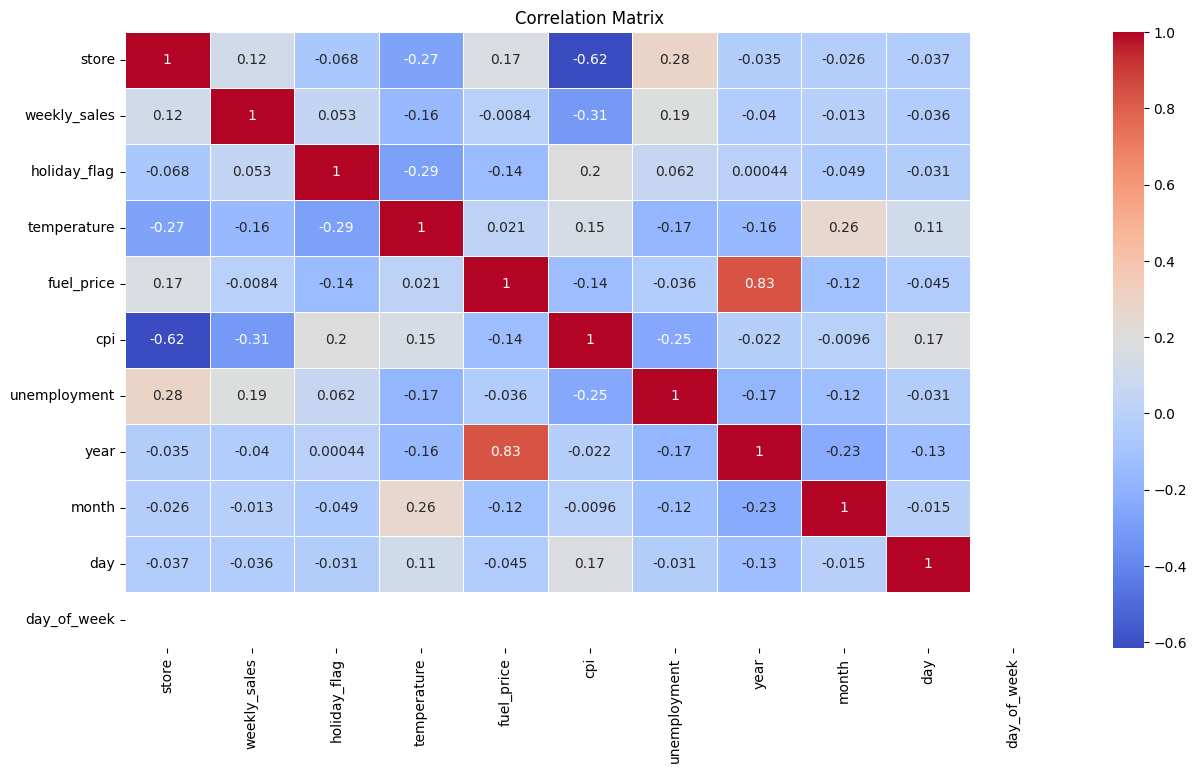

In [575]:
correlation_matrix = df.corr()
plt.figure(figsize=(15,8))
sns.heatmap(correlation_matrix, annot=True, linewidths=0.5, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

"cpi", "temperature" and "store" seem to be correlated to "weekly sales".

Let's separate the features and the target.

In [576]:
target_name = "weekly_sales"
features_list = [c for c in df.columns if c != target_name]

X = df.loc[:,features_list]
y = df.loc[:,target_name]

In [577]:
categorical_features = ['store', 'holiday_flag']
numeric_features = ['temperature', 'fuel_price', 'cpi', 'unemployment', 'year', 'month', 'day', 'day_of_week']

In [578]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=0)

categorical_transformer = Pipeline(
    steps=[
    ('encoder', OneHotEncoder(drop='first')),
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ])

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='mean'))
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

print("Performing preprocessings on the features")
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
print("Done...")

Performing preprocessings on the features
Done...


Let's train a baseline model.

In [579]:
regressor = LinearRegression()
regressor.fit(X_train, Y_train)

Y_train_pred = regressor.predict(X_train)
Y_test_pred = regressor.predict(X_test)

print("r2-score on train set : ", r2_score(Y_train, Y_train_pred))
print("r2-score on test set : ", r2_score(Y_test, Y_test_pred))

r2-score on train set :  0.9733207488128575
r2-score on test set :  0.935583016926107


That's a good score. But we will see if we can do better.

In [580]:
regressor.coef_

array([-3.91247047e+04, -3.94392908e+04,  8.23536302e+04, -1.01988627e+05,
       -2.37537278e+04,  6.85301670e+04, -3.46256136e+04, -1.45519152e-09,
        4.00290554e+05, -1.25872062e+06,  6.15511087e+05, -1.40995632e+06,
       -1.73986677e+04, -8.85671464e+05, -7.60531338e+05, -1.25430587e+06,
        6.71460002e+05,  1.05486249e+04,  5.42781493e+05,  7.24684873e+05,
       -6.77539227e+05, -1.11346349e+06, -6.74248103e+05, -1.52044191e+05,
        8.36903184e+04,  3.74133771e+05, -4.42105988e+04, -3.38711569e+04])

In [581]:
numeric_feature_names = numeric_features

categorical_encoder = preprocessor.named_transformers_['cat']['encoder']

one_hot_encoded_feature_names = categorical_encoder.get_feature_names_out(input_features=categorical_features)

all_feature_names = numeric_feature_names + list(one_hot_encoded_feature_names)

print(all_feature_names)

['temperature', 'fuel_price', 'cpi', 'unemployment', 'year', 'month', 'day', 'day_of_week', 'store_2.0', 'store_3.0', 'store_4.0', 'store_5.0', 'store_6.0', 'store_7.0', 'store_8.0', 'store_9.0', 'store_10.0', 'store_11.0', 'store_13.0', 'store_14.0', 'store_15.0', 'store_16.0', 'store_17.0', 'store_18.0', 'store_19.0', 'store_20.0', 'holiday_flag_1.0', 'holiday_flag_nan']


In [582]:
coefs = pd.DataFrame(index = all_feature_names, data = regressor.coef_.transpose(), columns=["coefficients"]).abs().sort_values(by="coefficients", ascending=False)
fig = px.bar(coefs, x= coefs.index, y ="coefficients")
fig.show()

The features "cpi", "fuel_price", "store", "temperature" seem to be relevant.

Let's train a regularized linear regression model.